# 进阶案例：中低阶API实现手写数字识别

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/advanced/mindspore_lenet_mnist.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/advanced/mindspore_lenet_mnist.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/advanced/lenet_mnist.ipynb)

MindSpore向用户提供了高阶、中阶和低阶3个不同层次的API，详细内容参见[基本介绍-层次结构内容章节](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/introduction.html#层次结构)。本章将使用MindSpore提供的中低阶API，以LeNet网络模型为例，实现深度学习中的手写数字识别任务。

本章将会介绍配置信息和使用MindSpore提供的中低阶API，实现自定义网络模型、数据加载，自定义训练、验证、推理流程。


## 数据集下载和处理

示例中用到的MNIST数据集是由10类28∗28的灰度图片组成，训练数据集包含60000张图片，测试数据集包含10000张图片。

![mnist](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/mnist.png)

### 数据集下载

以下示例代码是MNIST数据集下载并解压到指定位置。

In [2]:
import os
from mindvision.dataset import DownLoad

# 数据集下载
def download_data(url_mnist, data_name, mnist_path):

    mnist_data_file = [url_mnist + data_name[0],
                       url_mnist + data_name[1]]

    # 下载MNIST数据集并解压
    dl = DownLoad()
    dl.download_and_extract_archive(url=mnist_data_file[0], download_path=mnist_path)
    dl.download_and_extract_archive(url=mnist_data_file[1], download_path=mnist_path)

    # 删除压缩文件
    for i in os.listdir(mnist_path):
        if i in data_name:
            os.remove(mnist_path + i)

data_name_train = ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz"]
path_mnist_train = "./mnist/train/"
data_name_test = ["t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]
path_mnist_test = "./mnist/test/"
url_mnist = "http://yann.lecun.com/exdb/mnist/"

# 下载训练集
download_data(url_mnist, data_name_train, path_mnist_train)
# 下载验证集
download_data(url_mnist, data_name_test, path_mnist_test)

9913344B [00:03, 2535312.32B/s]                                                                                        
29696B [00:00, 9924625.62B/s]                                                                                          
1649664B [00:01, 899297.74B/s]                                                                                         
5120B [00:00, 5137520.69B/s]                                                                                           


### 数据集加载

使用[mindspore.dataset.MnistDataset](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/mindspore.dataset.MnistDataset.html#mindspore.dataset.MnistDataset)接口加载MNIST数据集，使用数据集增强函数生成训练数据，通过定义的`create_data_to_net`方法将生成的60000个数据增强为7500组shape为(8, 1, 32, 32)的数据集。示例代码如下：

The size of steps:  3750
The x label value shape: (16, 1, 32, 32)
The y label value shape: (16,)


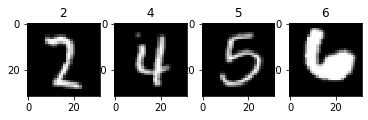

In [3]:
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from mindspore.dataset.transforms import Compose
import matplotlib.pyplot as plt

# 构建数据预处理
def create_data_to_net(minist_path, batch_size, image_size):
    # 加载数据
    dataset_mnist2 = ds.MnistDataset(minist_path)

    # 数据预处理方法
    transforms_list = [
        vision.Resize(size=image_size),
        vision.HWC2CHW()]
    compose_trans = Compose(transforms_list)
    dataset_mnist2 = dataset_mnist2.map(operations=compose_trans, input_columns=["image"])

    dataset_mnist = dataset_mnist2.batch(batch_size, drop_remainder=True)

    return dataset_mnist

batch_size = 16
image_size = [32, 32]

train_data = create_data_to_net(path_mnist_train, batch_size, image_size)
print("The size of steps: ", train_data.get_dataset_size())
dict_datasets = next(train_data.create_dict_iterator())
print("The x label value shape:", dict_datasets["image"].shape)
print("The y label value shape:", dict_datasets["label"].shape)

# 数据可视化
ds_test = train_data.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()
plt.figure()
for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
    plt.title(labels[i-1])
plt.show()

## 定义网络模型

按照LeNet的网络结构，LeNet除去输入层共有7层，其中有2个卷积层，2个子采样层，3个全连接层。模型结构如下图：

![](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/lenet.png)

`mindspore.nn`类是构建所有网络的基类，也是网络的基本单元。当用户需要自定义网络时，可以继承`nn.Cell`类，并重写`__init__`方法和`construct`方法。

为了便于管理和组成更复杂的网络，`mindspore.nn`提供了容器对网络中的子模型块或模型层进行管理，有`nn.CellList`和`nn.SequentialCell`两种方式。这里选择了使用`nn.CellList`方法。


In [4]:
from mindspore import nn
from mindspore.common.initializer import Normal

# 自定义网络
class MyNet(nn.Cell):
    def __init__(self, num_classes=10, num_channel=1):
        super(MyNet, self).__init__()
        layers = [nn.Conv2d(num_channel, 6, 5, pad_mode='valid'),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Conv2d(6, 16, 5, pad_mode='valid'),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Flatten(),
                  nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02)),
                  nn.ReLU(),
                  nn.Dense(120, 84, weight_init=Normal(0.02)),
                  nn.ReLU(),
                  nn.Dense(84, num_classes, weight_init=Normal(0.02))]
        # 使用CellList对网络进行管理
        self.build_block = nn.CellList(layers)

    def construct(self, x):
        # for循环执行网络
        for layer in self.build_block:
            x = layer(x)
        return x

## 自定义损失函数

损失函数（Loss Function）用于衡量预测值与真实值差异的程度。深度学习中，模型训练就是通过不停地迭代来缩小损失函数值的过程，因此在模型训练过程中损失函数的选择非常重要，定义一个好的损失函数可以帮助损失函数值更快收敛，达到更好的精度。

本文使用的是softmax交叉熵损失函数，公式如下：

$$p_{ij} = softmax(X_{ij}) = \frac{\exp(x_i)}{\sum_{j = 0}^{N-1}\exp(x_j)} \tag{1}$$

$$loss_{ij} = -\sum_j{Y_{ij} * ln(p_{ij})} \tag{2}$$

其中X为模型前向网络的输出，Y为标签值。

[mindspore.nn](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.nn.html#损失函数)提供了许多通用损失函数供用户选择， 也支持用户根据需要自定义损失函数。自定义损失函数类时，既可以继承网络的基类`nn.Cell`，也可以继承损失函数的基类`nn.LossBase`。`nn.LossBase`在`nn.Cell`的基础上，提供了`get_loss`方法，利用`reduction`参数对损失值求和或求均值，输出一个标量。下面将使用继承LossBase的方法来定义交叉熵损失函数(Cross Entropy Loss)，这里需要重写`__init__`方法和`construct`方法，使用`get_loss`方法计算损失。示例代码如下：

In [5]:
from mindspore import ops
from mindspore import Tensor
import mindspore.common.dtype as mstype

# 自定义损失函数
class MyLoss(nn.LossBase):
    def __init__(self):
        super(MyLoss, self).__init__()
        self.one_hot = ops.OneHot()
        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0., mstype.float32)
        self.softmax = ops.Softmax()
        self.mul = ops.Mul()
        self.op = ops.ReduceSum(keep_dims=True)

    def construct(self, logits, labels):
        # 对标签进行one hot编码
        labels = self.one_hot(labels, ops.shape(logits)[-1], self.on_value, self.off_value)
        x = self.softmax(logits)
        x = -ops.log(x)
        x = self.mul(labels, x)
        x = self.op(x, 1)
        x = x.repeat(1)
        return self.get_loss(x)

## 自定义优化器

优化器在模型训练过程中，用于计算和更新网络参数，合适的优化器可以有效减少训练时间，提高模型性能。

[mindspore.nn](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.nn.html#优化器)提供了许多通用的优化器供用户选择，同时也支持用户根据需要自定义优化器。

自定义优化器时可以继承优化器基类`nn.Optimizer`，重写`__init__`方法和`construct`方法实现参数的更新。

如下示例实现自定义优化器Momentum（带动量的SGD算法）：

$$ v_{t+1} = v_t × u+grad \tag{3}$$

$$p_{t+1} = p_t - lr × v_{t+1} \tag{4}$$

其中，$grad$(梯度) 、$lr$(学习率) 、$p$(权重参数) 、$v$(动量参数（Momentum）) 和 $u$(初始速度)。

In [6]:
# 自定义优化器
class MyMomentum(nn.Optimizer):
    def __init__(self, params, learning_rate, momentum=0.9):
        super(MyMomentum, self).__init__(learning_rate, params)
        self.moment = ms.Parameter(ms.Tensor(momentum, ms.float32), name="moment")
        self.momentum = self.parameters.clone(prefix="momentum", init="zeros")
        self.assign = ops.Assign()

    def construct(self, gradients):
        """construct输入为梯度，在训练中自动传入梯度gradients"""
        lr = self.get_lr()
        params = self.parameters  # 待更新的权重参数
        for i in range(len(params)):
            self.assign(self.momentum[i], self.momentum[i] * self.moment + gradients[i])
             # 带有动量的SGD算法
            update = params[i] - self.momentum[i] * lr
            # 将update赋值给params[i]
            self.assign(params[i], update)
        return params

## 自定义训练和验证流程

`mindspore.Model`提供了`train`和`eval`的接口方便用户在训练过程中使用，但此接口无法适用于所有场景，比如多数据多标签场景，在这些场景下用户需自行定义训练过程。

本节主要使用线性回归的例子来简单介绍自定义训练流程。首先定义损失网络，将前向网络与损失函数连接起来；然后定义训练流程，训练流程一般继承`nn.TrainOneStepCell`，`nn.TrainOneStepCell`封装了损失网络和优化器，用来实现反向传播网络以更新权重参数。

### 定义损失网络

定义损失网络`MyWithLossCell`，将前向网络与损失函数连接起来。代码如下：

In [7]:
class MyWithLossCell(nn.Cell):
    """定义损失网络"""

    def __init__(self, network, loss_fn):
        """实例化时传入前向网络和损失函数作为参数"""
        super(MyWithLossCell, self).__init__(auto_prefix=False)
        self.network = network
        self.loss_fn = loss_fn

    def construct(self, data, label):
        """连接前向网络和损失函数"""
        out = self.network(data)
        return self.loss_fn(out, label)

### 定义训练流程

定义训练流程`MyTrainStep`，该类继承`nn.TrainOneStepCell`，`nn.TrainOneStepCell`封装了损失网络和优化器，在执行训练时通过`ops.GradOperation`算子来进行梯度的获取，通过优化器来实现权重的更新。

In [8]:
# 定义训练过程
class MyTrainStep(nn.TrainOneStepCell):
    def __init__(self, network, optimizer):
        super(MyTrainStep, self).__init__(network, optimizer)
        self.grad = ops.GradOperation(get_by_list=True)

    def construct(self, data, label):
        # 构建训练过程
        weights = self.weights
        loss = self.network(data, label)
        grads = self.grad(self.network, weights)(data, label)
        self.optimizer(grads)
        return loss

### 定义验证流程

定义验证流程`MyWithEvalCell`，该类继承`nn.Cell`，这里需要用损失函数连接前向网络，需要输出损失、模型预测结果和标签值。

In [9]:
# 定义验证过程
class MyWithEvalCell(nn.Cell):
    def __init__(self, network, loss_fn):
        super(MyWithEvalCell, self).__init__(auto_prefix=False)
        self._network = network
        self._loss_fn = loss_fn

    def construct(self, data, label):
        # 构建验证过程
        outputs = self._network(data)
        label = ops.functional.mixed_precision_cast(mstype.float32, label)
        outputs = ops.functional.cast(outputs, mstype.float32)
        loss = self._loss_fn(outputs, label)
        return loss, outputs, label

### 执行训练和验证

训练验证流程是先生成数据，然后初始化相关模块，再构建训练过程，再构建验证过程，这里验证过程用到网络的权重共享，最后打印结果。这里epochs设置为10，并选择每个epochs保存一次权重文件，每个epochs用验证集数据做一次验证，便于观察模型的训练的效果，具体代码如下：

In [10]:
import time
import mindspore as ms

epochs = 10

# 生成数据
train_data = create_data_to_net(path_mnist_train, batch_size, image_size)
eval_data = create_data_to_net(path_mnist_test, batch_size, image_size)

# 初始化网络
net = MyNet()

# 初始化损失函数
loss = MyLoss()

# 初始化优化器
opt = MyMomentum(net.trainable_params(), learning_rate=0.0008, momentum=0.9)

# 构建损失网络
net_with_loss = MyWithLossCell(net, loss)

# 构建训练网络
train_net = MyTrainStep(net_with_loss, opt)

# 设置网络为训练模式
train_net.set_train()

# 构建验证网络
eval_net = MyWithEvalCell(net, loss)
eval_net.set_train(False)
loss_ = nn.Loss()
metric = nn.Accuracy('classification')

# 真正训练迭代过程
steps = train_data.get_dataset_size()

for epoch in range(epochs):
    start = time.time()
    for data in train_data.create_dict_iterator():
        result = train_net(ms.Tensor(data['image'], ms.float32), ms.Tensor(data["label"], ms.int32))
    end = time.time()
    time_ = round(end - start, 2)

    # 保存权重
    ms.save_checkpoint(train_net, f"./ckpt/epoch_{epoch}_MyNet.ckpt")

    metric.clear()
    loss_.clear()
    for data_eval1 in eval_data.create_dict_iterator():
        outputs = eval_net(ms.Tensor(data_eval1['image'], ms.float32), ms.Tensor(data_eval1["label"], ms.int32))
        metric.update(outputs[1], outputs[2])
        loss_.update(outputs[0])

    # 评估结果
    metric_result = metric.eval()
    loss_result = loss_.eval()

    print(f"Epoch:[{epoch}/{epochs}], "
          f"step:[{steps}/{steps}], "
          f"epoch_time:{time_}s, "
          f"train_loss:{result}, "
          f"acc:{metric_result}, "
          f"eval_loss:{loss_result}.")

Epoch:[0/10], step:[3750/3750], epoch_time:14.22s, train_loss:0.25353754, acc:0.9785, eval_loss:0.06721991033004597.
Epoch:[1/10], step:[3750/3750], epoch_time:12.6s, train_loss:0.012809625, acc:0.9832, eval_loss:0.05638552011344582.
Epoch:[2/10], step:[3750/3750], epoch_time:13.74s, train_loss:0.0019591202, acc:0.9856, eval_loss:0.04582654931277502.
Epoch:[3/10], step:[3750/3750], epoch_time:12.42s, train_loss:0.0023593744, acc:0.9861, eval_loss:0.0458989940400701.
Epoch:[4/10], step:[3750/3750], epoch_time:12.45s, train_loss:0.00030701322, acc:0.9878, eval_loss:0.042475348692122494.
Epoch:[5/10], step:[3750/3750], epoch_time:12.48s, train_loss:0.0038114265, acc:0.9888, eval_loss:0.03685572870048636.
Epoch:[6/10], step:[3750/3750], epoch_time:12.59s, train_loss:0.17087981, acc:0.9899, eval_loss:0.036158681892016646.
Epoch:[7/10], step:[3750/3750], epoch_time:13.09s, train_loss:0.0002066287, acc:0.9863, eval_loss:0.045936309088131386.
Epoch:[8/10], step:[3750/3750], epoch_time:12.77s, 

## 构建推理流程

我们使用生成的模型进行单个图片数据的分类预测，具体步骤如下：

> - 被预测的图片会随机生成，每次运行结果可能会不一样。
> - 代码使用了Tensor模块，阅读更多有关[张量Tensor](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/tensor.html)的信息。

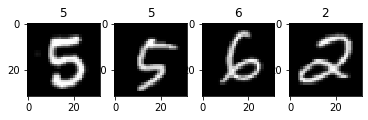

result:  [5, 5, 6, 2]


In [11]:
from mindspore import load_checkpoint, load_param_into_net

batch_size = 1
image_size = [32, 32]

# 初始化网络
net = MyNet()

# 初始化损失函数
loss = MyLoss()

# 加载权重文件
param_dict = load_checkpoint(f"./ckpt/epoch_{epoch}_MyNet.ckpt")
load_param_into_net(net, param_dict)

# 构建推理网络
eval_net = MyWithEvalCell(net, loss)
eval_net.set_train(False)

# 数据加载
infer_data = create_data_to_net(path_mnist_test, batch_size, image_size)
ds_test = train_data.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

# 模型推理
outputs = eval_net(ms.Tensor(data["image"], ms.float32), ms.Tensor(data["label"], ms.int32))

# 结果可视化
result = []
i = 1
plt.figure()
for i in range(1, 5):
    indices = outputs[1].argmax(axis=1)
    result.append(indices.asnumpy()[i-1])
    plt.subplot(1, 4, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
    plt.title(labels[i-1])
plt.show()

print("result: ", result)